In [1]:
"""
This notebook contains the Layer Analysis Technique, generates the LAT_stats.zip files and figures 2 and 5.
Inputs include the cross section photos, reference measurements and annotations

Author: Joshua Soderholm.
Contact: joshua.soderholm at bom.gov.au
"""

'\nThis notebook contains the Layer Analysis Technique, generates the LAT_stats.zip files and figures 2 and 5.\nInputs include the cross section photos, reference measurements and annotations\n\nAuthor: Joshua Soderholm.\nContact: joshua.soderholm at bom.gov.au\n'

In [3]:
# standard libraries
import gc
import json
import math
import os

# CV libraries
import cv2 as cv

# plotting libraries
import matplotlib
import matplotlib.colors as colors

# maths libraries
import numpy as np
import pandas as pd
import scipy
from matplotlib import pyplot as plt
from skimage import draw, filters, morphology, transform
from shapely.geometry import Polygon
from scipy import interpolate, ndimage

# turn off warnings
import warnings
warnings.simplefilter("ignore")

In [4]:
# setup paths for inputs

# folder containing images of a unique size
image_folder = "/home/meso/data/cross-section-paper-data/analysis/cropped_photos"
# csv file containing reference measurements
reference_csv_ffn = "/home/meso/data/cross-section-paper-data/analysis/cropped_photos/xsec_reference_measurements.csv" 
# json output from VIA tool containing (1) embryo centre (2) embryo polygon (3) measurement line
via_json_ffn = "/home/meso/data/cross-section-paper-data/analysis/cropped_photos/melb_20200119_hail.json"  

# setup paths for outputs

# annotated images
out_root = "/home/meso/data/cross-section-paper-data/analysis/paper_outputs/pipeline_img"  
# npy files containing stats
stats_root = "/home/meso/data/cross-section-paper-data/analysis/paper_outputs/pipeline_stats"
# images for composite figure
composite_eq_root = "/home/meso/data/cross-section-paper-data/analysis/paper_outputs/composite_eq"

In [5]:
def area_shapely(x, y):
    """
    Calculate area within polygon defined by x,y points
    Assumes x,y points go around the polygon in one direction.

    Parameter:
    ----------
    x: list of floats
        x coordinates list of polygon
    y: list of floats
        y coordinates list of polygon

    Returns:
    ----------
    float
        area of polygon
    """
    poly = Polygon(zip(x,y))
    return poly.area

def moving_average(a, n=3):
    """
    return the moving average of a 1D vector.
    total length is preserved by using same values on edges.

    Parameter:
    ----------
    a: ndarray (1,n)
        vector to apply moving average to
    n: int
        window size

    Returns:
    ----------
    ndarray (1,n)
        a with moving average filter applied
    """
    return np.convolve(a, np.ones((n,)) / n, mode="same")

def _find_layer_edge(data, threshold, edge_idx, mode='left'):
    """
    returns the index where data first falls below the threshold (and a argmin if this fails).

    Parameter:
    ----------
    data: ndarray (1,n)
        array to
    threshold: float
        data threhold for finding layer edge
    edge_idx: int
        index of edge pixel
    mode: string
        either 'left' or 'right'. defermines if the first or last index from np.where is used

    Returns:
    ----------
    layer_edge_idx: int
        index of the layer edge
    """
    try:
        # find the first/last data index below the threshold, which marks the right/left edge of the layer
        if mode=='left':
            layer_edge_idx = np.where(data < threshold)[0][-1]
        else:
            layer_edge_idx = np.where(data < threshold)[0][0]
    except Exception as e:
        # take the argmin if this fails
        layer_edge_idx = np.argmin(data)
    # enforce edge limit on peak right
    if layer_edge_idx > edge_idx:
        layer_edge_idx = edge_idx
    return layer_edge_idx
            
            
def find_peak_edges(data, peaks, pixel_size):

    """
    Find the width (left and right edges) of peaks within tha 1D array provided.
    Also returns the edge pixel (last pixel inside the hailstone).
    A secondary filtering is applied to all peaks

    Parameter:
    ----------
    data: ndarray (1,n)
        1D vector from which peaks have been identified
    peaks: ndarray (1,m)
        1D array of peak indices

    Returns:
    ----------
    left_array: ndarray (1,p)
        array of indicies for the left hand edge of filtered peak indicies
    right_array: ndarray (1,p)
        array of indicies for the right hand edge of filtered peak indicies
    peak_array: ndarray (1,p)
        filtered array of peak indicies

    edge_idx: int
        index of edge pixel

    """

    # config
    fall_perc = 0.30  # luminosity threshold use to find peak width (percentage)
    edge_dist = 1*pixel_size  # minimum distance a peak must be from the edge (mm)
    """
    First pass
    (1) Find the edge pixel
    (2) Find the left and right edges using the first pixel away from the peak which falls below the threshold.
    If this fails, use the argmin
    """
    
    #init
    left_pass_1 = []
    right_pass_1 = []

    # find edge pixel (first zero value)
    edge_idx = np.where(data > 0)[0][-1]

    #for each peak
    for peak_idx in peaks:
        # extract peak lumosity
        peak_lum = data[peak_idx]
        # extract threshold for lumosity
        peak_lower_limit = peak_lum - (peak_lum * fall_perc)
        #
        # right side
        #
        data_right = data.copy()
        # replace lum values on the left side of the peak with peak_lum, preserving the right side
        data_right[
            :peak_idx
        ] = peak_lum 
        #find right index
        layer_right_edge_idx = _find_layer_edge(data_right, peak_lower_limit, edge_idx, mode='right')
        right_pass_1.append(layer_right_edge_idx)
        #
        # left side
        #
        data_left = data.copy()
        # replace lum values on the right side of the peak with peak_lum, preserving the left side
        data_left[
            peak_idx:
        ] = peak_lum  
        #find left index
        layer_left_edge_idx = _find_layer_edge(data_left, peak_lower_limit, edge_idx, mode='left')
        left_pass_1.append(layer_left_edge_idx)
    #convert to arrays
    left_pass_1 = np.array(left_pass_1)
    right_pass_1 = np.array(right_pass_1)
    peak_pass_1 = np.array(peaks)

    """
    Second pass
    # merge overlapping peaks
    """
    
    # init
    left_pass_2 = []
    right_pass_2 = []
    peak_pass_2 = []
    proc_flag = np.zeros_like(left_pass_1, dtype=bool) #used to mark if peak has already been processed
    
    #loop through each peak
    for i, peak in enumerate(peak_pass_1):
        # check if already processed
        if proc_flag[i]:
            continue
        #
        # (1) check if layer extends from the centre (erase and skip)
        #
        if left_pass_1[i] == 0:
            # write -999 which removed this peak in pass 3 (using the width)
            left_pass_1[i] = -999
            right_pass_1[i] = -999
            continue
        #
        # (2) find if layer edges overlap with other layers
        #
        current_left = left_pass_1[i]
        current_right = right_pass_1[i]
        # find other overlaps on the left side of the current peak
        overlap_left = np.logical_and(
            current_left <= right_pass_1, peak >= peak_pass_1
        ) 
        # find other overlaps on the right side of the current peak
        overlap_right = np.logical_and(
            current_right >= left_pass_1, peak <= peak_pass_1
        )
        # combine overlaps and index
        overlap = np.where(np.logical_or(overlap_left, overlap_right))[0]  

        # find min of those points
        left_pass_2.append(np.min(left_pass_1[overlap]))
        right_pass_2.append(np.max(right_pass_1[overlap]))
        overlap_peak_lum = data[
            peak_pass_1[overlap]
        ]  # find luminosity values of overlapping peaks
        peak_pass_2.append(
            peak_pass_1[overlap[np.argmax(overlap_peak_lum)]]
        )  # only append the index of the highest luminosity value
        # assign as processed
        proc_flag[overlap] = True

    """
    Third pass
    - remove layers close to the edge
    """
    left_pass_3 = []
    right_pass_3 = []
    peak_pass_3 = []
    for i, left_edge in enumerate(left_pass_2):
        # check distance from edge to peak
        if (edge_idx - left_edge) > edge_dist:
            left_pass_3.append(left_pass_2[i])
            right_pass_3.append(right_pass_2[i])
            peak_pass_3.append(peak_pass_2[i])
            
    # output
    left_array = np.array(left_pass_3)
    right_array = np.array(right_pass_3)
    peak_array = np.array(peak_pass_3)

    return left_array, right_array, peak_array, edge_idx

    
def process_layers(layer_peaks_idx, layer_density_smooth, range_dim, area_dim):
    
    """
    For a given list of layer peaks, determine the edges of each peak, the surface area and the weighted centre

    Parameter:
    ----------
    layer_peaks_idx: ndarray (1,m)
        array of indicies for layer peak locations
    layer_density_smooth: ndarray (n)
        1D array of smoothed opaque layer count (across all transects)
    range_dim: list (n)
        list of range dimension (pixel units)
    area_dim: ndarray (n)
        1D array of pixel area for each range bin

    Returns:
    ----------
    layer_left_edge_idx: list (m)
        array of indicies for the left hand edge of filtered peak indicies (pixel units)
    layer_right_edge_idx: list (m)
        array of indicies for the right hand edge of filtered peak indicies (pixel units)
    layer_sa_list: list (m)
        list of surface area for each opaque layer (pixel units)
    layer_weighted_centre_list: list (m)
        list of weighted centroid (index along range dim) for each opaque layer

    """
    
    # for each layer peak, find layer edges centre of mass and total count
    layer_left_edge_idx = []
    layer_right_edge_idx = []
    layer_sa_list = []
    layer_weighted_centre_list = []
    for i, peak in enumerate(layer_peaks_idx):
        # find index of upper and lower minimum
        if i == 0:
            left_edge = np.where(layer_density_smooth > 0)[0][
                0
            ]  # first nonzero value before the first peak
        else:
            left_edge = layer_peaks_idx[i - 1] + np.argmin(
                layer_density_smooth[layer_peaks_idx[i - 1] : peak]
            )

        if i + 1 == len(layer_peaks_idx):
            right_edge = (
                peak + np.where(layer_density_smooth[peak:] == 0)[0][0]
            )  # first zero value after the final peak
        else:
            right_edge = peak + np.argmin(
                layer_density_smooth[peak : layer_peaks_idx[i + 1]]
            )
        layer_left_edge_idx.append(left_edge)
        layer_right_edge_idx.append(right_edge)
        # calculate count
        layer_sa = (
            layer_density_smooth[left_edge : right_edge + 1]
            * area_dim[left_edge : right_edge + 1]
        )
        layer_sa_list.append(np.sum(layer_sa))
        # calculate centre of mass radius
        radius_sum = np.sum(layer_sa * range_dim[left_edge : right_edge + 1])
        layer_weighted_centre_list.append(radius_sum / np.sum(layer_sa))

    return layer_left_edge_idx, layer_right_edge_idx, layer_sa_list, layer_weighted_centre_list

In [49]:
def worker(image_ffn, c_coord, ref_coord, emb_coord, img_ref_mm):

    """
    primary function for analysing hailstone layers

    Parameter:
    ----------
    image_ffn: string
        path to image filename (must be resized first using resize_img.ipynb)
    c_coord: list of two floats
        pixel coordinates of hailstone centre [cx, cy]
    ref_coord: list of two lists (which contain floats)
        pixel coordinates of reference measurement start and end point [x_points_list, y_points_list]
    emb_coord: list of two lists (which contain floats)
        pixel coordinates of polygon boundary for embryo [x_points_list, y_points_list]
    img_ref_mm: float
        reference measurement for ref_coord in units of mm

    Returns:
    ----------
    None
    """
    
    
    # parameters 
    gaussian_filter_sigma = 4 #sigma value used for gaussian smoothing filter
    azimuth_spacing = 5  # spacing between transects (degrees)
    target_pixel_size = 30 #used to resize image and for measurements, units of pix/mm
    
    # for detecting layers within each ray (step 1)
    ray_prominence = 25  # minimum vertical distance to neighbouring samples to define a peak (relative value; Image intensity units)
    ray_distance = 2*target_pixel_size  # minimum horizontal distance in samples between neighbouring peaks (mm)
    ray_height = 80  # minimum height of peaks (absolute value; Image intensity units)
    
    # for detecting layers from all rays (step 2)
    layer_smoothing = 10 #moving average window applied to smooth layer density analysis (pixel units)
    layer_min_with = int(30/azimuth_spacing)  # minimum width used to define a layer azi dim steps (deg)
    layer_prominence = 10  # minimum vertical distance to neighbouring samples to define a layer (relative value; opaque layer count)
    layer_distance = 2*target_pixel_size   # minimum horizontal distance in samples between neighbouring layers (Pixels)

    # extract image ID
    img_fn = os.path.basename(image_ffn)
    img_id = img_fn[0:2]
    print("processing", image_ffn)
    
    # unpack lists
    cx, cy = c_coord
    ref_coord_x, ref_coord_y = ref_coord
    
    # work out pixel scaling using reference length
    ref_len = np.sqrt(
        (ref_coord_x[0] - ref_coord_x[1]) ** 2 + (ref_coord_y[0] - ref_coord_y[1]) ** 2
    )
    ref_pix_mm = ref_len / img_ref_mm #pixels/mm
    #scaling to resize image
    resize_scaling = target_pixel_size/ref_pix_mm #ratio
    
    # read image file using opencv2
    img_data = cv.imread(image_ffn)
    # transform image into hsv colorspace
    img_data_hls = cv.cvtColor(img_data, cv.COLOR_BGR2HLS)
    # extract luminosity channel
    lum_img = img_data_hls[:, :, 1]
    #rescale to ensure consistent pixel size
    lum_img = transform.rescale(lum_img, resize_scaling,
                       anti_aliasing=True)
    img_size = np.shape(lum_img)
    # apply gaussian filter
    lum_img_smooth = filters.gaussian(lum_img, sigma=gaussian_filter_sigma) * 255
    
    #rescale annotations
    cx = cx*resize_scaling
    cy = cy*resize_scaling
    ref_coord_x = np.array(ref_coord_x)*resize_scaling
    ref_coord_y = np.array(ref_coord_y)*resize_scaling

    # work out embryo surface area
    if emb_coord is None:
        emb_sa = None
    else:
        # calculate surface area (rescaling)
        emb_coord_x = np.array(emb_coord[0])*resize_scaling
        emb_coord_y = np.array(emb_coord[1])*resize_scaling
        emb_sa = area_shapely(emb_coord_x, emb_coord_y) / (target_pixel_size**2)
    """
    PEAK ANALYSIS (FOR EACH TRANSECTS)
    """
    
    # define and plot transect lines
    pixel_range = np.max(img_size)  # pixels (max possible distance)
    # init dimenions for transects
    azimuth_dim = np.arange(0, 360, azimuth_spacing)
    range_dim = np.arange(0, pixel_range)
    range_bin = range_dim[1] - range_dim[0]
    azi_bin = azimuth_dim[1] - azimuth_dim[0]
    # calculate area of each ray bin (pixel units
    area_dim = np.zeros_like(range_dim)
    for i, bin_range in enumerate(range_dim):
        area_dim[i] = (
            (
                ((bin_range + (range_bin / 2)) ** 2) * math.pi
                - ((bin_range - (range_bin / 2)) ** 2) * math.pi
            )
            / 360
            * azi_bin
        )

    # init array to store layers (-1: outside, 0: translucent, 1: opaque, 2: rejected opaque 
    layer_array = np.zeros((pixel_range, len(azimuth_dim))) - 1  # set all to be outside

    # init lists for debugging
    line_x_list = []
    line_y_list = []
    line_lum_list = []
    peaks_idx_list = []
    peaks_width_list = []
    # init lists for analysis/plotting
    peaks_x_list = []
    peaks_y_list = []
    peaks_azi_list = []
    cl_x_list = []
    cl_y_list = []
    cr_x_list = []
    cr_y_list = []
    edge_idx_list = []

    # for each azimuth, analyse the transect.
    for i, azi in enumerate(azimuth_dim):
        # create indicies for lines from centroid along search azimuth rays
        end_x = int(
            cx + pixel_range * math.cos(math.radians(azi))
        )
        end_y = int(cy + pixel_range * math.sin(math.radians(azi)))
        # generate line points
        line_x = np.linspace(cx, end_x, pixel_range).astype(np.int)
        line_y = np.linspace(cy, end_y, pixel_range).astype(np.int)
        # enforce boundaries
        mask_x = np.logical_and(line_x >= 0, line_x <= img_size[1] - 1)
        mask_y = np.logical_and(line_y >= 0, line_y <= img_size[0] - 1)
        mask = np.logical_and(mask_x, mask_y)
        line_x = line_x[mask]
        line_y = line_y[mask]

        # extract data along transect
        line_lum = lum_img_smooth[line_y, line_x].astype(int)
        # measure peaks along traject using scipy find_peaks function: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.find_peaks.html
        peaks_idx, _ = scipy.signal.find_peaks(
            line_lum,
            prominence=ray_prominence,
            distance=ray_distance,
            height=ray_height,
        )

        # find edges of peaks in trasect, and edge of hailstone
        left_idx, right_idx, new_peak_idx, edge_idx = find_peak_edges(
            line_lum, peaks_idx, target_pixel_size
        )

        # create representative array from peak edges and hailstone edge for storing in layer_array
        layer_vec = np.zeros(
            pixel_range,
        )
        for j, _ in enumerate(new_peak_idx):
            layer_vec[left_idx[j] : right_idx[j] + 1] = 1
        layer_vec[edge_idx:] = -1
        layer_array[:, i] = layer_vec

        # skip storing layer parameters if there's no peaks
        if len(new_peak_idx) == 0:
            continue

        # store transect outputs for debugging
        line_x_list.append(line_x)
        line_y_list.append(line_y)
        line_lum_list.append(line_lum)
        peaks_idx_list.append(new_peak_idx)
        peaks_width_list.append(right_idx - left_idx)
        # store transect outputs for layer analysis and plotting
        peaks_x_list.append(line_x[new_peak_idx])
        peaks_y_list.append(line_y[new_peak_idx])
        peaks_azi_list.append(np.zeros_like(new_peak_idx) + azi)
        cl_x_list.append(line_x[left_idx])
        cl_y_list.append(line_y[left_idx])
        cr_x_list.append(line_x[right_idx])
        cr_y_list.append(line_y[right_idx])
        edge_idx_list.append(edge_idx)

    """
    LAYER ANALYSIS (ACROSS ALL TRANSECTS)
    """
    # flatten centre info arrays
    cl_x_array = np.concatenate(cl_x_list).ravel() # left x values
    cl_y_array = np.concatenate(cl_y_list).ravel() # left y values
    cr_x_array = np.concatenate(cr_x_list).ravel() # right x values
    cr_y_array = np.concatenate(cr_y_list).ravel() # right y values
    peak_idx_array = np.concatenate(peaks_idx_list).ravel() # peak index
    peak_x_array = np.concatenate(peaks_x_list).ravel() # peak location x
    peak_y_array = np.concatenate(peaks_y_list).ravel() # peak location y
    peaks_azi_array = np.concatenate(peaks_azi_list).ravel() # peak azimuth

    # remove regions from layer_array which have a continuous azuimuthal length of less than layer_min_with
    layer_mlabel = morphology.label(layer_array == 1) #label regions
    label_max = np.max(layer_mlabel)
    azimuth_grid, _ = np.meshgrid(azimuth_dim, range_dim) #create azimuthal grid
    for label in range(1, label_max + 1):
        #determine azimuthal width by number of unique azimuthal values
        unqiue_azi_set = np.unique(azimuth_grid[layer_mlabel == label])
        azi_width = len(unqiue_azi_set) 
        if azi_width <= layer_min_with:
            layer_array[layer_mlabel == label] = 2 #assigned to "filtered out"  

            
    # need to separate layers and preserve their representation in the range-azimuth space.
    # something more intelligent.
    # start from a random azimuth, index each layer
    # move to next layer, transfer index for layers which overlaps by > 50%, otherwise start a new layer index
    layer_valid = layer_array == 1
    layer_label = np.zeros_like(layer_valid, dtype=int)
    tmp_label, num_layers = ndimage.label(layer_valid[:, 0])
    layer_label[:, 0] = tmp_label
    next_layer_idx = num_layers + 1
    #loop through radials
    for i, azi in enumerate(azimuth_dim):
        print('radial', i)
        if i == 0:
            continue
        #label new radial
        tmp_labels, tmp_num_layers = ndimage.label(layer_valid[:, i])
        #loop through each "test" layer in the new radial
        for j in range(1, tmp_num_layers):
            #mask for "test" layer j
            print('layer', j)
            test_layer_mask = tmp_labels == j
            test_layer_len = np.sum(test_layer_mask)
            #extract labels from previous radial for the "test" layer
            last_radial_overlap = layer_label[:, i-1][test_layer_mask]
            
            
            print('last_radial_overlap', np.where(test_layer_mask))
            #not working - cannot recover last radial indicies
            
            
            
            #loop through unique labels from previous radial
            for k in np.unique(last_radial_overlap):
                if k == 0 and len(np.unique(last_radial_overlap)) == 0:
                    #new layer, no overlaps
                    layer_label[:, i][test_layer_mask] = next_layer_idx
                    next_layer_idx =+ 1
                    print('assigned new index', next_layer_idx-1)
                elif k > 0 and np.sum(last_radial_overlap==k) >= np.round(test_layer_len/2):
                    #check if number of pixels in overlapping label from previous radial is larger 50% of the test layer
                    layer_label[:, i][test_layer_mask] = k
                    print('assigned old index', k)
    
    plt.pcolor(azimuth_dim, range_dim/target_pixel_size, layer_label, vmin=0, vmax=10)
    
    
#     # compute number of times an opaque layer detected as a function of range for all transects
#     layer_valid = layer_array == 1
#     layer_density = np.sum(layer_valid, axis=1)
#     # smooth to reduce noise
#     layer_density_smooth = moving_average(layer_density, layer_smoothing)
#     # find layers in opaque density analysis
#     layer_peaks_idx, _ = scipy.signal.find_peaks(
#         layer_density_smooth, prominence=layer_prominence, distance=layer_distance
#     )
    
#     # # compute the normalised (radially) layers dataset
#     # norm_range = int(pixel_range/2)
#     # norm_layer_array = np.zeros((norm_range, len(azimuth_dim))) - 1 
#     # norm_range_dim = np.linspace(0, 100, norm_range)
#     # for i, azi in enumerate(azimuth_dim):
#     #     input_radial = layer_array[:edge_idx_list[i],i]
#     #     input_range = np.linspace(0, 100, len(input_radial))
#     #     f = interpolate.interp1d(input_range, input_radial, kind='nearest')
#     #     norm_layer_array[:,i] = f(norm_range_dim)
    
#     #process layer peaks to find edges, and layer stats
#     layer_left_edge_idx, layer_right_edge_idx, layer_sa_list, layer_weighted_centre_list = process_layers(layer_peaks_idx, layer_density_smooth, range_dim, area_dim)

#     """
#     PLOTTING
#     """
    
#     ###########################################################################################
#     # MAIN PLOT
#     ###########################################################################################
    
#     fig = plt.figure(facecolor="white", figsize=[12, 11])
#     fig.suptitle(f"Hailstone {img_id}", fontsize=16)

#     ###########################################################################################
#     # subplot 1: hailstone image overlaid with annotations and trajections
#     ###########################################################################################
    
#     ax = plt.subplot(221)
#     plt.gca().invert_yaxis()
#     # plot image
#     plt.imshow(lum_img_smooth, cmap="gray")
#     for i, _ in enumerate(cl_x_array):
#         if i == 0:
#             # mark peaks
#             plt.plot(peak_x_array[i], peak_y_array[i], "b.", markersize=8, label="Local peak")
#             # mark edges
#             plt.plot(
#                 [cl_x_array[i], cr_x_array[i]],
#                 [cl_y_array[i], cr_y_array[i]],
#                 "b-",
#                 label="Local peak width",
#             )
#         else:  # plot without labels
#             # mark peaks
#             plt.plot(peak_x_array[i], peak_y_array[i], "b.", markersize=8)
#             # mark edges
#             plt.plot(
#                 [cl_x_array[i], cr_x_array[i]], [cl_y_array[i], cr_y_array[i]], "b-"
#             )
#     # plot centroid
#     plt.plot(cx, cy, "r*", markersize=16, label="Embryo centre")
#     # plot embryo
#     try:
#         plt.plot(emb_coord_x, emb_coord_y, "r-", linewidth=3, label="Embryo edge")
#     except:
#         # no dry embryo
#         pass
#     # plot reference measurement
#     plt.plot(ref_coord_x, ref_coord_y, "r--", linewidth=3, label="Reference measurement")
    
    
#     plt.legend(loc="lower left")
#     plt.axis("off")
#     plt.title("(a) Manual Annotations and Transects", fontsize=14)

#     ###########################################################################################
#     # subplot 2: plot layer_array as a azimuth/range image to explore layers
#     ###########################################################################################
#     plt.subplot(222)
    
#     # define colormap for layer_array
#     hail_colors = ["black", "dimgrey", "white", "yellow"]
#     hail_cmap = colors.ListedColormap(hail_colors)
#     #plot layer_array as image
#     img = plt.pcolor(
#         azimuth_dim, range_dim/target_pixel_size, layer_array, vmin=-1.5, vmax=2.5, cmap=hail_cmap
#     )
#     #create colorbar
#     cbar = plt.colorbar(img, ticks=[-1, 0, 1, 2], orientation="horizontal")
#     cbar.ax.set_xticklabels(
#         ["Background", "Translucent layer", "Opaque layer", "Invalid opaque layer"],
#     fontsize=8)
#     plt.axis("auto")
#     plt_range = np.max(edge_idx_list)/target_pixel_size + 5
#     plt.ylim([0, plt_range])
#     plt.xlabel("Azimuth (deg.)")
#     plt.ylabel("Distance from embryo centroid (mm)")
#     plt.title("(b) Candidate layer regions detected from transects", fontsize=14)

#     ###########################################################################################
#     # subplot 3: plot layer density as a function of range to explore layer extraction
#     ###########################################################################################
#     plt.subplot(223)
#     #plot range density
#     plt.plot(range_dim/target_pixel_size, layer_density_smooth, "k--")
#     #plot layer peak locations
#     plt.plot(
#         range_dim[layer_peaks_idx]/target_pixel_size,
#         layer_density_smooth[layer_peaks_idx],
#         marker="o",
#         markerfacecolor="b",
#         linewidth=0,
#         label="Peak",
#         markersize=8,
#     )
#     #plot layer weighted centre locations
#     plt.plot(
#         np.array(layer_weighted_centre_list)/target_pixel_size,
#         layer_density_smooth[np.array(layer_weighted_centre_list).astype("int")],
#         marker="o",
#         markerfacecolor="k",
#         linewidth=0,
#         label="Area weighted centre",
#         markersize=8,
#     )
#     #plot left edge locations
#     plt.plot(
#         range_dim[layer_left_edge_idx]/target_pixel_size,
#         layer_density_smooth[layer_left_edge_idx],
#         marker=7,
#         markerfacecolor="b",
#         linewidth=0,
#         label="Layer edge",
#         markersize=8,
#     )
#     #plot right edge locations
#     plt.plot(
#         range_dim[layer_right_edge_idx]/target_pixel_size,
#         layer_density_smooth[layer_right_edge_idx],
#         marker=7,
#         markerfacecolor="b",
#         linewidth=0,
#         markersize=8,
#     )
#     plt.xlim([0, plt_range])
#     plt.ylim([-1, np.max(layer_density_smooth) + 5])
#     plt.xlabel("Distance from embryo centroid (mm)")
#     plt.ylabel("Layer aggregation")
#     plt.title("(c) Consolidated transects", fontsize=14)
#     plt.legend()

#     ###########################################################################################
#     # subplot 4: plot equivalent cross section
#     ###########################################################################################
#     ax = plt.subplot(224)
#     #setup axis
#     ax.set_xlabel("(mm)")
#     ax.set_ylabel("(mm)")
#     ax.set_facecolor("black")
#     # draw hailstone edge using mean edge distance
#     mean_edge_radius = np.mean(edge_idx_list) / target_pixel_size #
#     background = plt.Circle((0, 0), mean_edge_radius, color="dimgrey")
#     ax.add_artist(background)
#     output_sa_array = [] #this is exported as a stat, not plotted
#     output_inner_array = []
#     output_output_array = []
#     #for each layer
#     for i in range(len(layer_sa_list) - 1, -1, -1):  # loop backwards to plot inner layers first
#         r = layer_weighted_centre_list[i] / target_pixel_size
#         sa = layer_sa_list[i] / (target_pixel_size ** 2)
#         output_sa_array.append(sa)
#         #calculate the inner and outer radius of each layer, centred on the weighted centre for a given sa (units of mm)
#         r_inner = math.sqrt(r ** 2 - (sa / (2 * math.pi)))
#         r_outer = math.sqrt((sa / (2 * math.pi)) + r ** 2)
        
#         if r_outer>mean_edge_radius:
#             mean_edge_radius=r_outer
#         output_inner_array.append(r_inner)
#         output_output_array.append(r_outer)
        
#         #plot layer as a white circle overlaid with a grey circle
#         circle_inner = plt.Circle((0, 0), r_inner, color="dimgrey")
#         circle_outer = plt.Circle((0, 0), r_outer, color="white")
#         ax.add_artist(circle_outer)
#         ax.add_artist(circle_inner)
#     # draw equivalent embryo
#     if emb_sa is not None:
#         # use embryo surface area to calculate equivalent radius
#         r_embryo = np.sqrt(emb_sa / math.pi)
#         circle_embryo = plt.Circle((0, 0), r_embryo, color="white")
#         ax.add_artist(circle_embryo)
#     grid_coord = [-35, -25, -15, -5, 5, 15, 25, 35]
#     for i in grid_coord:
#         plt.plot([i, i], [-40, 40], "y:", lw=2)
#         plt.plot([-40, 40], [i, i], "y:", lw=2)
        
#     ax.set_xlim((-40, 40))
#     ax.set_ylim((-40, 40))
#     ax.set_aspect('equal')
#     plt.title("(d) Equivalent Circular Cross Section", fontsize=14)
    
    
    
#     # export and save figure
#     plt.tight_layout()
#     plt.savefig(f"{out_root}/analysis_{os.path.basename(image_ffn)}")
#     plt.clf()
#     plt.close("all")
    
#     ###########################################################################################
#     # second plot: plot equivalent cross section in it's own figure
#     ###########################################################################################
    
#     # draw equivalent circular hail in its own figure
#     fig = plt.figure(figsize=[10, 10])
#     fig.set_facecolor("k")
#     ax = plt.subplot(111)
#     ax.set_aspect("equal")
#     ax.set_facecolor("k")
#     # draw entire hail
#     mean_edge_radius = np.mean(edge_idx_list) / target_pixel_size
#     background = plt.Circle((0, 0), mean_edge_radius, color=[0.5, 0.5, 0.5])
#     ax.add_artist(background)
#     for i in range(len(layer_sa_list) - 1, -1, -1):  # loop backwards to plot inner layers first
#         r = layer_weighted_centre_list[i] / target_pixel_size
#         sa = layer_sa_list[i] / (target_pixel_size ** 2)
#         #calculate the inner and outer radius of each layer, centred on the weighted centre for a given sa (units of mm)
#         r_inner = math.sqrt(r ** 2 - (sa / (2 * math.pi)))
#         r_outer = math.sqrt((sa / (2 * math.pi)) + r ** 2)
#         circle_inner = plt.Circle((0, 0), r_inner, color=[0.5, 0.5, 0.5])
#         circle_outer = plt.Circle((0, 0), r_outer, color="w")
#         ax.add_artist(circle_outer)
#         ax.add_artist(circle_inner)
#     # draw equivalent embryo
#     if emb_sa is not None:
#         # use embryo surface area to calculate equivalent radius
#         r_embryo = np.sqrt(emb_sa / math.pi)
#         circle_embryo = plt.Circle((0, 0), r_embryo, color="w")
#         ax.add_artist(circle_embryo)
#     # draw grids on plot
#     x = (np.arange(0, img_size[1]) - int(img_size[1] / 2)) / target_pixel_size
#     y = (np.arange(0, img_size[0]) - int(img_size[0] / 2)) / target_pixel_size
#     grid_coord = [-35, -25, -15, -5, 5, 15, 25, 35]
#     for i in grid_coord:
#         plt.plot([i, i], [-40, 40], "y:", lw=2)
#         plt.plot([-40, 40], [i, i], "y:", lw=2)
#     ax.set_xlim((-40, 40))
#     ax.set_ylim((-40, 40))
#     # export plot
#     ax.set_axis_off()
#     plt.savefig(
#         f"{composite_eq_root}/resized_eq_{os.path.basename(image_ffn)}",
#         bbox_inches="tight",
#         pad_inches=0,
#     )
#     plt.clf()
#     plt.close("all")

#     # export stats
#     max_edge_radius = np.max(edge_idx_list) / target_pixel_size
#     np.savez(
#         f"{stats_root}/stats_{img_id}.npz",
#         mean_edge_radius = mean_edge_radius,
#         output_sa_array = np.array(output_sa_array),
#         output_inner_array = np.array(output_inner_array),
#         output_output_array = np.array(output_output_array)
#     )
    
#     gc.collect()

In [50]:
"""
build arguements for the worker function using reference_csv_ffn and via_json_ffn
"""

#read reference sizes dataset
df = pd.read_csv(reference_csv_ffn)

#build image file and centroid arguments from annotation json file
worker_args_list = []
with open(via_json_ffn) as json_fh:  
    data = json.load(json_fh)
    #for each image in the annoation file
    for item in data.keys():
        #extract image name and id
        img_fn = data[item]['filename']
        img_id = int(img_fn[0:2])
        #extract shape variables
        c_coord = None
        ref_coord = None
        emb_coord = None
        for shape in data[item]['regions']:
            shape = shape['shape_attributes']
            if shape['name'] == 'point':
                c_coord = [shape['cx'], shape['cy']]
            if shape['name'] == 'polygon':                
                emb_coord_x = shape['all_points_x']
                emb_coord_y = shape['all_points_y']
                #close polygon
                emb_coord = [emb_coord_x + [emb_coord_x[0]], emb_coord_y + [emb_coord_y[0]]]
            if shape['name'] == 'polyline':
                ref_coord = [shape['all_points_x'], shape['all_points_y']]    
        if emb_coord == None:
            print('no dry embryo for', img_id)
        #check for missing metadata
        if c_coord == None or ref_coord == None:
            print('error: missing json data for if', img_id)
            continue
        #extract reference measurement
        try:
            img_ref_mm = float(df.size_mm[df.id==img_id])
        except:
            print('error: failed to find reference measurement to match id', img_id)
            continue
        #build args
        worker_args_list.append((f'{image_folder}/{img_fn}', c_coord, ref_coord, emb_coord, img_ref_mm))

no dry embryo for 2
no dry embryo for 5
no dry embryo for 9
no dry embryo for 24
no dry embryo for 25
no dry embryo for 31


processing /home/meso/data/cross-section-paper-data/analysis/cropped_photos/01.png
radial 0
radial 1
radial 2
layer 1
last_radial_overlap (array([ 72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,
        85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,
        98,  99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110,
       111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123,
       124, 125, 126, 127, 128, 129, 130, 131]),)
radial 3
layer 1
last_radial_overlap (array([ 77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133]),)
radial 4
layer 1
last_radial_overlap (array([ 73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,
        86,  87,  88,  89,  90,  91,  92,  93,  94, 

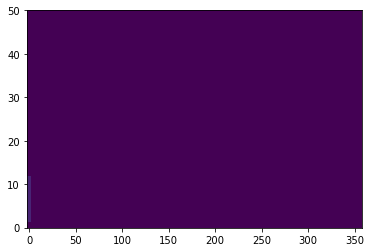

In [51]:
#run worker for all images
for item in worker_args_list:
    worker(*item)
    break